In [1]:
import matplotlib.pyplot as plt
#%matplotlib inline
#import IPython.display
#import librosa.display
import numpy as np
import librosa
import tensorflow as tf

In [2]:
import glob
uav_path = '../data/phantom/JUNE_01_PHANTOMS/wavs/*.wav'
none_path = '../data/phantom/JUNE_02_BACKGROUND/wavs/background/background_0*.wav'
uav_files = glob.glob(uav_path)
none_files = glob.glob(none_path)

In [3]:
CHUNK_SIZE = 8192
SR = 44100
N_MFCC = 13

In [4]:
def load(files, sr=44100):
    [raw, sr] = librosa.load(files[0], sr=sr)
    for f in files[1:]:
        [array, sr] = librosa.load(f, sr=sr)
        raw = np.hstack((raw, array))
    print(raw.shape,sr)
    return raw

In [5]:
uav_raw = load(uav_files)
none_raw = load(none_files)

(9732096,) 44100
(18579456,) 44100


### mfcc incremental

In [6]:
def mfcc(raw, chunk_size=8192, sr=44100, n_mfcc=13):
    mfcc = np.empty((13, 0))
    for i in range(0, len(raw), chunk_size):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc)
        mfcc = np.hstack((mfcc, mfcc_slice))
    return mfcc

In [7]:
mfcc_uav = mfcc(uav_raw)
mfcc_none = mfcc(none_raw)

In [8]:
print(mfcc_uav.shape)
print(mfcc_none.shape)

(13, 20196)
(13, 38556)


In [9]:
# or should we give one label to one chunk?
y_uav = np.ones(mfcc_uav.shape[1], dtype=int)
y_none =np.zeros(mfcc_none.shape[1], dtype=int)

print(y_uav.shape)
print(y_none.shape)

(20196,)
(38556,)


In [10]:
X = np.hstack((mfcc_uav, mfcc_none)).T
y = np.hstack((y_uav, y_none))
print(X.shape, y.shape)

(58752, 13) (58752,)


In [11]:
n_labels = y.shape[0]
n_unique_labels = 2
y_encoded = np.zeros((n_labels, n_unique_labels))
y_encoded[np.arange(n_labels), y] = 1
print(y_encoded.shape)

(58752, 2)


In [12]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [13]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(47001, 13) (11751, 13)
(47001, 2) (11751, 2)


In [14]:
np.save('../data/Xy/X_train2', X_train)
np.save('../data/Xy/X_test2', X_test)
np.save('../data/Xy/y_train2', y_train)
np.save('../data/Xy/y_test2', y_test)

In [15]:
X_train = np.load('../data/Xy/X_train2.npy')
X_test = np.load('../data/Xy/X_test2.npy')
y_train = np.load('../data/Xy/y_train2.npy')
y_test = np.load('../data/Xy/y_test2.npy')

# Tensorflow finally!

## Training

### Parameters
- need feedback on this!

In [16]:
n_dim = 13 #X_train.shape[1]
n_classes = 2
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [31]:
training_epochs = 1500

In [18]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)


W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.global_variables_initializer()

In [19]:
cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [20]:
print(X_train.shape, y_train.shape)

(47001, 13) (47001, 2)


In [32]:
model_path = '../models/FCNN/my_test_model'
saver = tf.train.Saver()

In [33]:
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:X_train,Y:y_train})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: X_test})
    y_true = sess.run(tf.argmax(y_test,1))
    saver.save(sess, model_path)

### Below is for later when testing with pretrained model

In [23]:
with tf.Session() as sess:
    #sess.run(init)
    saver.restore(sess, model_path)
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: X_test})
    y_true = sess.run(tf.argmax(y_test,1))
print(y_pred.shape,y_true.shape)

INFO:tensorflow:Restoring parameters from ../models/my_test_model
(11751,) (11751,)


## Results
- Batch training and batch testing

#### epoch=3200

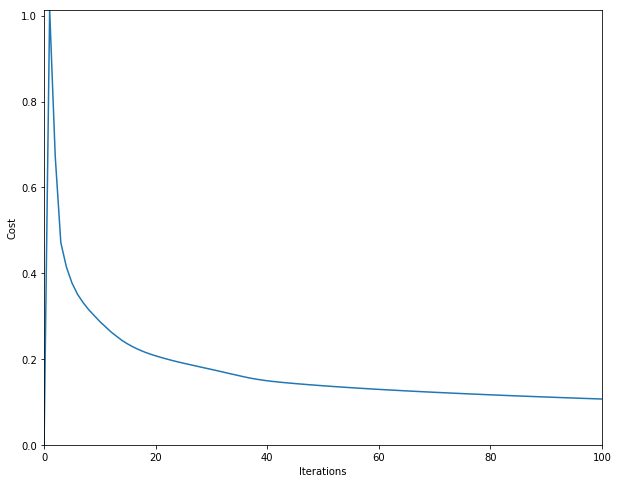

F-Score: 0.973
Accuracy:  0.9729384733214195
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      7719
          1       0.96      0.97      0.96      4032

avg / total       0.97      0.97      0.97     11751

[[7540  179]
 [ 139 3893]]


In [24]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

#### epoch=1600

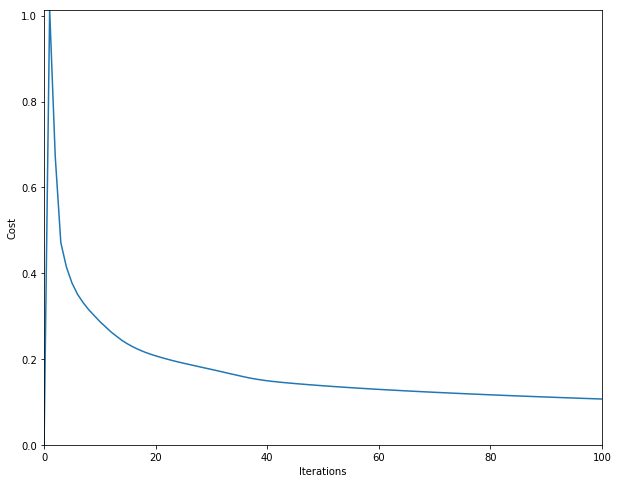

F-Score: 0.973
Accuracy:  0.9729384733214195
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      7719
          1       0.96      0.97      0.96      4032

avg / total       0.97      0.97      0.97     11751

[[7540  179]
 [ 139 3893]]


In [25]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

#### epoch=800

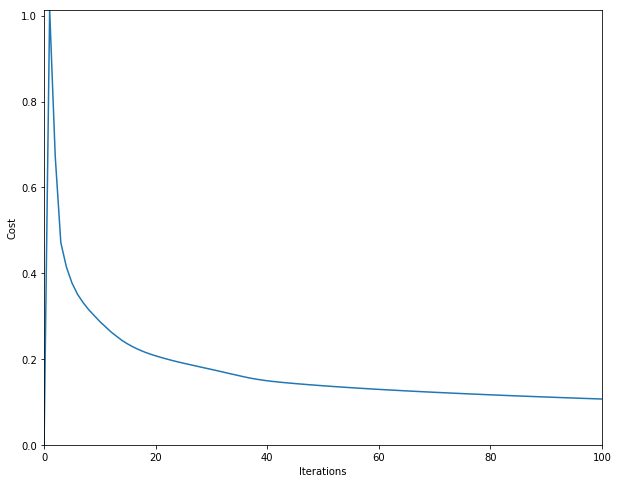

F-Score: 0.973
Accuracy:  0.9729384733214195
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      7719
          1       0.96      0.97      0.96      4032

avg / total       0.97      0.97      0.97     11751

[[7540  179]
 [ 139 3893]]


In [26]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

#### epoch=400

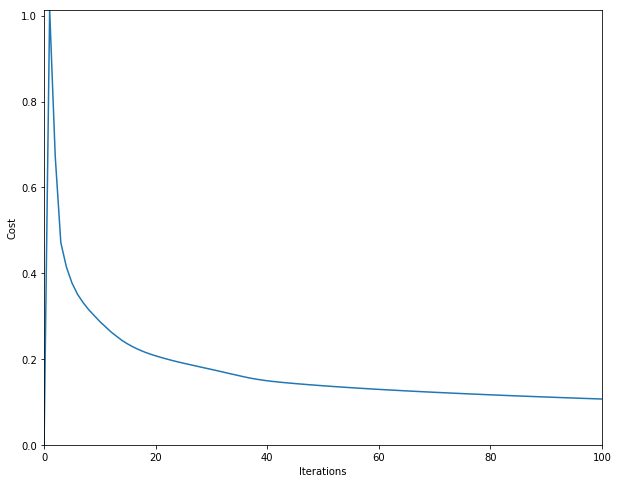

F-Score: 0.973
Accuracy:  0.9729384733214195
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      7719
          1       0.96      0.97      0.96      4032

avg / total       0.97      0.97      0.97     11751

[[7540  179]
 [ 139 3893]]


In [27]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

#### epoch=200

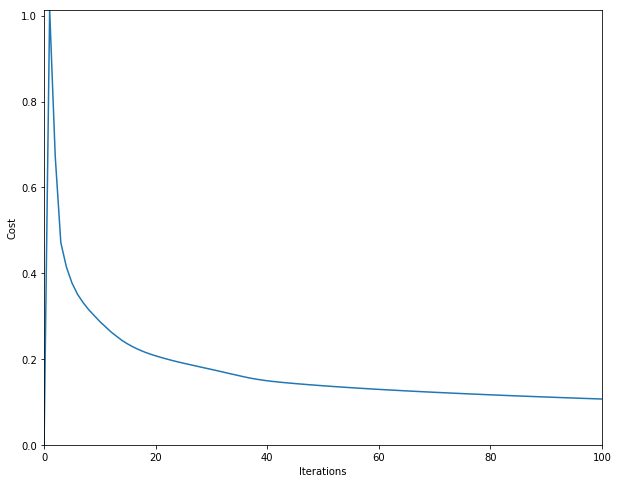

F-Score: 0.973
Accuracy:  0.9729384733214195
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      7719
          1       0.96      0.97      0.96      4032

avg / total       0.97      0.97      0.97     11751

[[7540  179]
 [ 139 3893]]


In [28]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

#### epoch=100

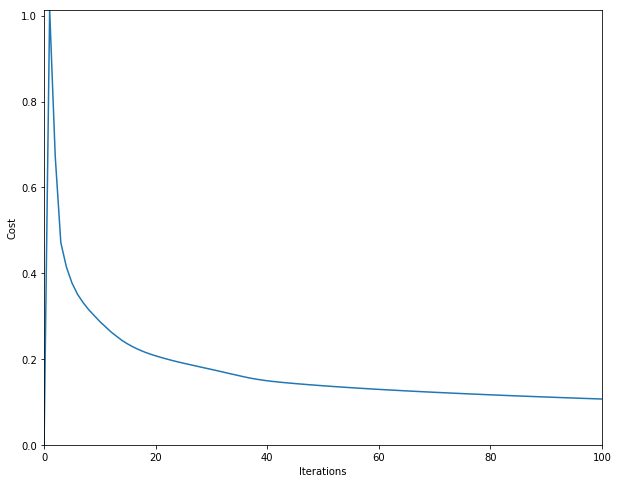

F-Score: 0.973
Accuracy:  0.9729384733214195
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      7719
          1       0.96      0.97      0.96      4032

avg / total       0.97      0.97      0.97     11751

[[7540  179]
 [ 139 3893]]


In [29]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

#### epoch=20

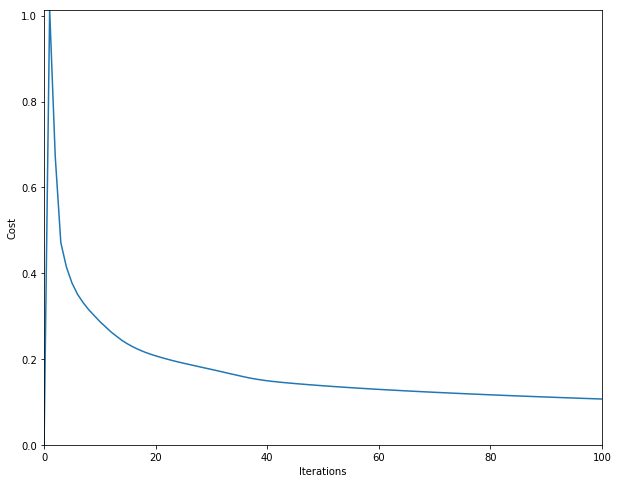

F-Score: 0.973
Accuracy:  0.9729384733214195
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      7719
          1       0.96      0.97      0.96      4032

avg / total       0.97      0.97      0.97     11751

[[7540  179]
 [ 139 3893]]


In [30]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))